In [3]:
import numpy as np
import scipy.misc
import random

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/AAIC/SelfDrivingCar

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/AAIC/SelfDrivingCar


In [0]:
import imageio
from PIL import Image
import csv

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
import os
len(os.listdir('Autopilot-Data/driving_dataset/'))

45570

In [0]:
xs = []
ys = []

train_batch_pointer = 0
val_batch_pointer = 0

#read data.txt
with open("Autopilot-Data/driving_dataset/data.txt") as f:
    for line in f:
        xs.append("Autopilot-Data/driving_dataset/" + line.split()[0])
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)

train_xs = xs[:int(len(xs) * 0.7)]
train_ys = ys[:int(len(xs) * 0.7)]

val_xs = xs[-int(len(xs) * 0.3):]
val_ys = ys[-int(len(xs) * 0.3):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)

def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
      image_read = Image.open(train_xs[(train_batch_pointer + i) % num_train_images])
      width, height = image_read.size
      image_np = np.array(image_read.crop((0, height-150, width, height)).resize((200, 66)))/255.0

      x_out.append(image_np)
      y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadValBatch(batch_size):
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
      image_read = Image.open(val_xs[(val_batch_pointer + i) % num_val_images])
      width, height = image_read.size
      image_np = np.array(image_read.crop((0, height-150, width, height)).resize((200, 66)))/255.0

      x_out.append(image_np)
      y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out

In [0]:
print(num_images)
print(num_train_images)
print(num_val_images)

45406
31784
13621


In [0]:
import tensorflow as tf
import scipy

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride):
  return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = tf.multiply(tf.subtract(tf.sigmoid(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 0.5), 6)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


**I have trained the model before for 20 epochs and lost the output of that training while re-training the model. I am loading the model which is saved after 20 epochs and continue the training for 10 epochs.**

In [0]:
import os
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2

sess = tf.InteractiveSession()
saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)
saver.restore(sess, "save/model.ckpt")

INFO:tensorflow:Restoring parameters from save/model.ckpt


In [0]:
L2NormConst = 0.0008

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(y_, y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(loss)
sess.run(tf.variables_initializer(optimizer.variables()))

In [0]:
epochs = 30
batch_size = 100

xs, ys = LoadValBatch(batch_size)
loss_value = loss.eval(session=sess, feed_dict={x: xs, y_: ys, keep_prob: 0.5})
print(loss_value)

0.4121355


In [12]:
LOGDIR = './save'

tf.summary.scalar("loss", loss)
merged_summary_op =  tf.summary.merge_all()

logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 10
batch_size = 100

for epoch in range(epochs):
  for i in range(int(num_images/batch_size)):
    xs, ys = LoadTrainBatch(batch_size)
    train_step.run(feed_dict={x: xs, y_: ys, keep_prob: 0.5})
    if i % 10 == 0:
      xs, ys = LoadValBatch(batch_size)
      loss_value = loss.eval(feed_dict={x: xs, y_: ys, keep_prob: 0.5})
      print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    if i % batch_size == 0:
      if not os.path.exists(LOGDIR):
        os.makedirs(LOGDIR)
      checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
      filename = saver.save(sess, checkpoint_path)
  print("Model saved in file: %s" % filename)

Epoch: 0, Step: 0, Loss: 0.0916611
Epoch: 0, Step: 10, Loss: 0.148379
Epoch: 0, Step: 20, Loss: 0.172696
Epoch: 0, Step: 30, Loss: 0.230764
Epoch: 0, Step: 40, Loss: 0.147943
Epoch: 0, Step: 50, Loss: 0.141621
Epoch: 0, Step: 60, Loss: 0.175908
Epoch: 0, Step: 70, Loss: 0.283319
Epoch: 0, Step: 80, Loss: 0.37651
Epoch: 0, Step: 90, Loss: 0.0978904
Epoch: 0, Step: 100, Loss: 0.0919006
Epoch: 0, Step: 110, Loss: 0.130484
Epoch: 0, Step: 120, Loss: 0.195051
Epoch: 0, Step: 130, Loss: 0.360338
Epoch: 0, Step: 140, Loss: 0.381405
Epoch: 0, Step: 150, Loss: 0.67947
Epoch: 0, Step: 160, Loss: 0.257504
Epoch: 0, Step: 170, Loss: 0.40641
Epoch: 0, Step: 180, Loss: 0.314718
Epoch: 0, Step: 190, Loss: 0.0949893
Epoch: 0, Step: 200, Loss: 0.104561
Epoch: 0, Step: 210, Loss: 0.120982
Epoch: 0, Step: 220, Loss: 0.216759
Epoch: 0, Step: 230, Loss: 0.733162
Epoch: 0, Step: 240, Loss: 0.177054
Epoch: 0, Step: 250, Loss: 1.82733
Epoch: 0, Step: 260, Loss: 0.57624
Epoch: 0, Step: 270, Loss: 0.567414
Epoc

**I am calculating predicted steering angles here and storing them to use later in opencv which will be run on desktop python.**

In [0]:
 from tqdm import tqdm

In [14]:
out_file = open('test-predictions.csv', 'w')
csv_writer = csv.writer(out_file)
csv_writer.writerow(['fileID', 'steering_angle'])

23

In [0]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save/model.ckpt")

smoothed_angle = 0
angle_ouputs = []

ind = 0

for img_path in val_xs:

    image_read = Image.open(img_path)
    width, height = image_read.size
    image_np = np.array(image_read.crop((0, height-150, width, height)).resize((200, 66)))/255.0

    degrees = y.eval(feed_dict={x: [image_np], keep_prob: 0.5})[0][0] * 180 / scipy.pi

    print(f'{ind}/{num_val_images} => Actual: {val_ys[ind]*180/scipy.pi}, Predicted: {degrees}')
    angle_ouputs.append(degrees)
    csv_writer.writerow([img_path, degrees])
    ind+=1
out_file.close()

INFO:tensorflow:Restoring parameters from save/model.ckpt
0/13621 => Actual: -28.34, Predicted: -5.427264899397547
1/13621 => Actual: -28.840000000000003, Predicted: -20.333435593087525
2/13621 => Actual: -29.75, Predicted: 0.3480117985904897
3/13621 => Actual: -31.06, Predicted: -7.314056846289379
4/13621 => Actual: -32.27, Predicted: -1.3425419832577064
5/13621 => Actual: -33.48, Predicted: 11.470804107227003
6/13621 => Actual: -34.39, Predicted: 3.897326430976786
7/13621 => Actual: -35.599999999999994, Predicted: -7.315767808676467
8/13621 => Actual: -36.5, Predicted: 1.6497570619357098
9/13621 => Actual: -37.61, Predicted: -0.30260470098824493
10/13621 => Actual: -38.62, Predicted: -6.179309708150971
11/13621 => Actual: -39.63, Predicted: 27.89608400440869
12/13621 => Actual: -39.93000000000001, Predicted: -16.625308817214677
13/13621 => Actual: -40.03000000000001, Predicted: 47.54959134109437
14/13621 => Actual: -40.03000000000001, Predicted: 2.4323942879816207
15/13621 => Actual:

### Conclusion:

**Conclusion:**
- **I have tried a lot of models and pick the model that did best which is above model. Even though the log-loss is not that good, the video result is good. I am listing some of the observations below.**
- **I have tried linear but couldnt achieve good results. The steering angle is constant.**
- **So I took sigmoid function as the shape of graph is slightly similar to arcTan but even after some trails I didnt get good results. I got constant output near 0 degrees.**
- **I have tried several combinations of sigmoid and linear and finally took 6(sigmoid-0.5) as my final activation function. This is because if we draw both plots we get almost similar graphs. (Will plot at end of the notebook).**
- **Even with this model I didnt get good results after trying with different dropouts.**
- **At last I reduced the normalization coefficient to 0.0008 as I thought my model is underfitting and kept the Adam learning rate back to 1e-4 these values worked fine for me and gave better results.**

**I trained the model and calculated predicted steering angles here and stored them to use later in opencv which will be run on desktop python. I will attach .py file as well to see the opencv code.**

**Video Observations:**
- **There is lot of sudden movements (jerks) in the steering. And there is no proper continuity in the angles.**
- **The right angles seems to be amplified a bit and left angles seems to be weakened a bit.**
- **First few seconds of the video is not good showing extreme right turn even when it is not good. But later part of video is quite good.**
- **And most of the time the steering angle's polarity is correct (polarity: left or right) even though the amplitude of the turn is incorrect.**

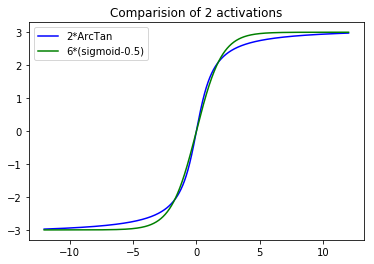

In [4]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

arctan_x = []
sigmoid_x = []
x_s = np.arange(-12, 12, 0.01)
for x in x_s:
  arctan_x.append(2*math.atan(x))
  sigmoid_x.append(6*(sigmoid(x)-0.5))

plt.plot(list(x_s), arctan_x, c='b', label='2*ArcTan')
plt.plot(list(x_s), sigmoid_x, c='g', label='6*(sigmoid-0.5)')
plt.legend()
plt.title("Comparision of 2 activations")
plt.show()